✅ Environment ready



Saving Day10_Healthcare_Compliance_Data.csv to Day10_Healthcare_Compliance_Data.csv
✅ Loaded: Day10_Healthcare_Compliance_Data.csv  |  Rows: 120
Columns: ['Case_ID', 'Department', 'Category', 'Priority', 'Status', 'Created_Date', 'Resolution_Time_Days', 'Regulatory_Flag']

Train size: 96 | Test size: 24
Categorical: ['Department', 'Category', 'Priority', 'Status']
Numeric: ['Resolution_Time_Days', 'Created_Month', 'Created_DOW']

ROC-AUC  LogisticRegression: 0.469
ROC-AUC  RandomForest      : 0.527
🏆 Using best model: RandomForest
Auto-selected threshold for best F1: 0.052 (Prec: 0.35, Rec: 1.00)

📋 Classification report (best model):
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        16
           1      0.333     1.000     0.500         8

    accuracy                          0.333        24
   macro avg      0.167     0.500     0.250        24
weighted avg      0.111     0.333     0.167        24



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


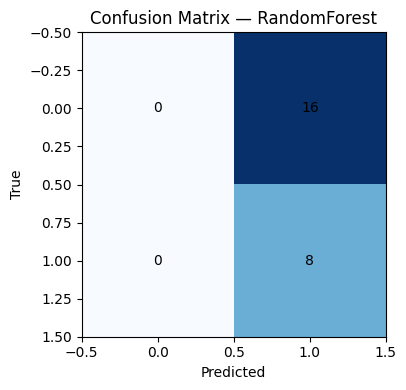

💾 Saved: /content/exports/predictions_regulatory_flag.csv
💾 Saved: /content/exports/agg_department_predicted_flags.csv
💾 Saved: /content/exports/agg_category_predicted_flags.csv
💾 Saved: /content/exports/top30_high_risk_cases.csv
💾 Saved: /content/exports/feature_importance_top20.csv


,feature,importance
15,Resolution_Time_Days,0.164632
17,Created_DOW,0.131493
16,Created_Month,0.088637
13,Status_Open,0.083048
14,Status_Resolved,0.078237
7,Category_Medical Records,0.055077
6,Category_Insurance Claim,0.045621
8,Priority_High,0.038194
4,Category_Billing Dispute,0.036573
1,Department_Claims Processing,0.036370



📝 Summary:
Model: RandomForest | AUC=0.527 | Threshold=0.05
Predicted regulatory risk on test set: 100.0% of cases.
Highest predicted risk by department: Billing (100%); Claims Processing (100%); Compliance Review (100%)
Highest predicted risk by category: Billing Dispute (100%); HIPAA Inquiry (100%); Insurance Claim (100%)

✅ Done. Files are in /content/exports. Use files.download(...) to fetch them, or zip the folder:
!zip -r exports.zip /content/exports


from matplotlib import pyplot as plt
fi['importance'].plot(kind='hist', bins=20, title='importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
fi['importance'].plot(kind='line', figsize=(8, 4), title='importance')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:


# 0) Setup
import os, io, numpy as np, pandas as pd, matplotlib.pyplot as plt
from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve)

pd.set_option("display.max_colwidth", 160)
os.makedirs("/content/exports", exist_ok=True)
print(" Environment ready")

# 1) Upload your CSV
print("")
uploaded = files.upload()  # choose your CSV

if not uploaded:
    raise SystemExit("No file uploaded. Please upload your CSV.")

DATA_PATH = list(uploaded.keys())[0]
df = pd.read_csv(DATA_PATH)
print(f" Loaded: {DATA_PATH}  |  Rows: {len(df):,}")
print("Columns:", list(df.columns))

# 2) Basic cleaning / feature engineering
# Target: Regulatory_Flag (Yes/No) -> 1/0
if "Regulatory_Flag" not in df.columns:
    raise ValueError("Expected column 'Regulatory_Flag' not found. Please include it.")

target = df["Regulatory_Flag"].map({"Yes":1, "No":0})
if target.isna().any():
    raise ValueError("Regulatory_Flag must contain only 'Yes'/'No' values.")

df["_target"] = target

# Parse date & add time features if present
if "Created_Date" in df.columns:
    dt = pd.to_datetime(df["Created_Date"], errors="coerce")
    df["Created_Month"] = dt.dt.month
    df["Created_DOW"]   = dt.dt.dayofweek
else:
    df["Created_Month"] = np.nan
    df["Created_DOW"]   = np.nan

# Numeric features (adjust if your file has different names)
num_cols = [c for c in ["Resolution_Time_Days", "Resolution_Time_Hours", "Created_Month", "Created_DOW"]
            if c in df.columns]

# Categorical features commonly in your dataset
cat_candidates = ["Department", "Category", "Priority", "Status"]
cat_cols = [c for c in cat_candidates if c in df.columns]

# Filter rows with valid target
data = df.dropna(subset=["_target"]).copy()

# 3) Train/test split
X = data[cat_cols + num_cols].copy()
y = data["_target"].astype(int).values

# Handle all-nan numeric feature columns if any
for c in num_cols:
    if X[c].isna().all():
        X.drop(columns=[c], inplace=True)
num_cols = [c for c in num_cols if c in X.columns]

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, data.index, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {len(X_train):,} | Test size: {len(X_test):,}")
print("Categorical:", cat_cols)
print("Numeric:", num_cols)

# 4) Preprocess + Models
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ],
    remainder="drop"
)

logit = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=500, random_state=42, class_weight="balanced"))
])

# Fit both & compare
logit.fit(X_train, y_train)
rf.fit(X_train, y_train)

proba_logit = logit.predict_proba(X_test)[:,1]
proba_rf    = rf.predict_proba(X_test)[:,1]

auc_logit = roc_auc_score(y_test, proba_logit)
auc_rf    = roc_auc_score(y_test, proba_rf)

print(f"\nROC-AUC  LogisticRegression: {auc_logit:.3f}")
print(f"ROC-AUC  RandomForest      : {auc_rf:.3f}")

# Pick the better model by AUC
best_name, best_model, best_proba = ("RandomForest", rf, proba_rf) if auc_rf >= auc_logit else ("LogisticRegression", logit, proba_logit)
print(f" Using best model: {best_name}")

# 5) Choose threshold (maximize F1 on validation set using PR curve)
prec, rec, thr = precision_recall_curve(y_test, best_proba)
f1 = 2 * (prec*rec) / (prec+rec + 1e-9)
ix = np.nanargmax(f1)
best_thresh = thr[ix-1] if ix > 0 and ix < len(thr) else 0.5  # safe fallback
print(f"Auto-selected threshold for best F1: {best_thresh:.3f} (Prec: {prec[ix]:.2f}, Rec: {rec[ix]:.2f})")

y_pred = (best_proba >= best_thresh).astype(int)

print("\n📋 Classification report (best model):")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4.5,4))
plt.imshow(cm, cmap="Blues")
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Predicted"); plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()

# 6) Build Excel-friendly exports
# Predictions on test set
test_out = data.loc[idx_test, ["Case_ID"] if "Case_ID" in data.columns else data.columns[0]].copy()
test_out = test_out.rename(columns={test_out.columns[0]:"Case_ID"})
test_out["Department"] = data.loc[idx_test, "Department"] if "Department" in data.columns else ""
test_out["Category"]   = data.loc[idx_test, "Category"] if "Category" in data.columns else ""
test_out["Priority"]   = data.loc[idx_test, "Priority"] if "Priority" in data.columns else ""
test_out["Status"]     = data.loc[idx_test, "Status"] if "Status" in data.columns else ""
if "Resolution_Time_Days" in data.columns:
    test_out["Resolution_Time_Days"] = data.loc[idx_test, "Resolution_Time_Days"]
test_out["True_Flag"]  = y_test
test_out["Prob_Flag"]  = best_proba.round(4)
test_out["Pred_Flag"]  = y_pred

pred_path = "/content/exports/predictions_regulatory_flag.csv"
test_out.to_csv(pred_path, index=False)
print(" Saved:", pred_path)

# Aggregates for Excel pivots
def safe_group(df_in, cols):
    cols = [c for c in cols if c in df_in.columns]
    return df_in.groupby(cols).size().reset_index(name="cases") if cols else pd.DataFrame()

agg_dept = test_out.groupby("Department").agg(
    cases=("Case_ID","count"),
    predicted_flags=("Pred_Flag","sum")
).reset_index()
agg_dept["predicted_flag_rate"] = (agg_dept["predicted_flags"]/agg_dept["cases"]).round(3)

agg_cat = test_out.groupby("Category").agg(
    cases=("Case_ID","count"),
    predicted_flags=("Pred_Flag","sum")
).reset_index()
agg_cat["predicted_flag_rate"] = (agg_cat["predicted_flags"]/agg_cat["cases"]).round(3)

agg_dept_path = "/content/exports/agg_department_predicted_flags.csv"
agg_cat_path  = "/content/exports/agg_category_predicted_flags.csv"
agg_dept.to_csv(agg_dept_path, index=False)
agg_cat.to_csv(agg_cat_path, index=False)
print(" Saved:", agg_dept_path)
print(" Saved:", agg_cat_path)

top_risk = test_out.sort_values("Prob_Flag", ascending=False).head(30)
top_risk_path = "/content/exports/top30_high_risk_cases.csv"
top_risk.to_csv(top_risk_path, index=False)
print(" Saved:", top_risk_path)

# 7) Simple feature importance (RandomForest only)
if best_name == "RandomForest":
    # Get feature names after one-hot
    ohe = best_model.named_steps["prep"].named_transformers_["cat"]
    num_passthrough = [c for c in num_cols]
    cat_names = ohe.get_feature_names_out(cat_cols)
    feature_names = list(cat_names) + num_passthrough
    importances = best_model.named_steps["clf"].feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi = fi.sort_values("importance", ascending=False).head(20)
    fi_path = "/content/exports/feature_importance_top20.csv"
    fi.to_csv(fi_path, index=False)
    print(" Saved:", fi_path)
    display(fi)

# 8) Auto-generated plain-English summary (paste into LinkedIn if you like)
pos_rate = test_out["Pred_Flag"].mean()
dept_line = agg_dept.sort_values("predicted_flag_rate", ascending=False).head(3)
cat_line  = agg_cat.sort_values("predicted_flag_rate", ascending=False).head(3)

summary = [
    f"Model: {best_name} | AUC={max(auc_rf, auc_logit):.3f} | Threshold={best_thresh:.2f}",
    f"Predicted regulatory risk on test set: {pos_rate:.1%} of cases.",
    "Highest predicted risk by department: " + "; ".join([f"{r.Department} ({r.predicted_flag_rate:.0%})" for _, r in dept_line.iterrows()]) if len(dept_line) else "",
    "Highest predicted risk by category: " + "; ".join([f"{r.Category} ({r.predicted_flag_rate:.0%})" for _, r in cat_line.iterrows()]) if len(cat_line) else ""
]
summary_text = "\n".join([s for s in summary if s])
with open("/content/exports/LINKEDIN_SUMMARY.txt", "w") as f:
    f.write(summary_text)
print("\n Summary:\n" + summary_text)

print("\n Done. Files are in /content/exports. Use files.download(...) to fetch them, or zip the folder:")
print("!zip -r exports.zip /content/exports")


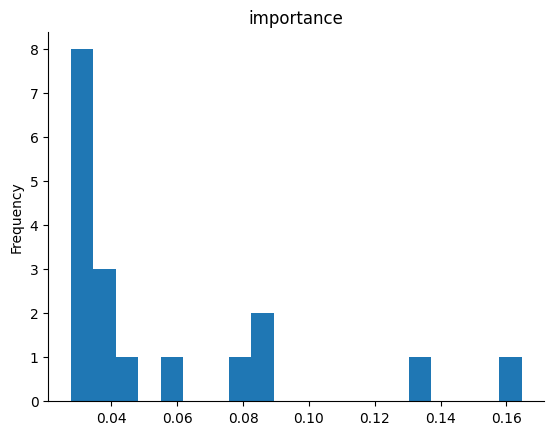

In [ ]:
from matplotlib import pyplot as plt
fi['importance'].plot(kind='hist', bins=20, title='importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

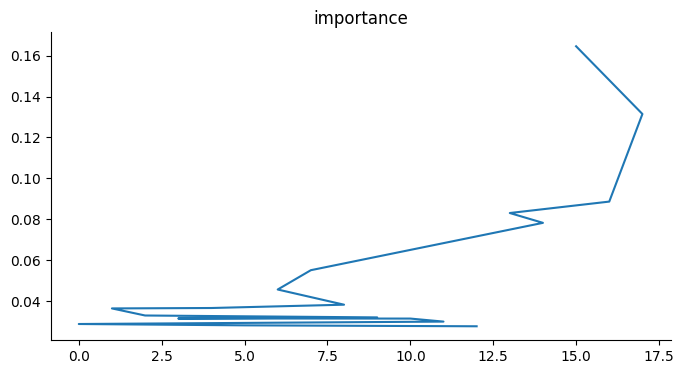

In [ ]:
from matplotlib import pyplot as plt
fi['importance'].plot(kind='line', figsize=(8, 4), title='importance')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=fi)

https://docs.google.com/spreadsheets/d/1DMMVKrqERLVMUiJZhV2s0wuNtSNThHucYwI75FCwKgw/edit#gid=0
